<a href="https://colab.research.google.com/github/brian-ho/intro-to-urban-data/blob/main/S10_Class_Demos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import GeoPandas to work with geometry
import geopandas as gpd

# Import the Path object to make working with file paths easier
from pathlib import Path

#Joins and Spatial Joins

In [5]:
DATA_DIRECTORY = '/content/drive/MyDrive/Cornell AAP - MSAUD/ARCH 6131/Example Data/Cornell Example Data/'

In [8]:
# Create this via geojson.io
# Make sure the file only has one geometry
bbox_gdf = gpd.read_file('map.geojson')
bbox_gdf

,geometry
0,"POLYGON ((-74.02385 40.71705, -74.02385 40.692..."


In [22]:
# Load the buildings dataset from the Shapefile
# Use the bounding box you created in geojson.io
# Convert this to the NY State Plane coordinate reference system
# See https://epsg.io/2263 for more details
buildings_gdf = gpd.read_file(
    Path(DATA_DIRECTORY) / 'building',
    bbox=bbox_gdf,
    use_arrow=True
).to_crs(2263)

(192000.0, 200000.0)

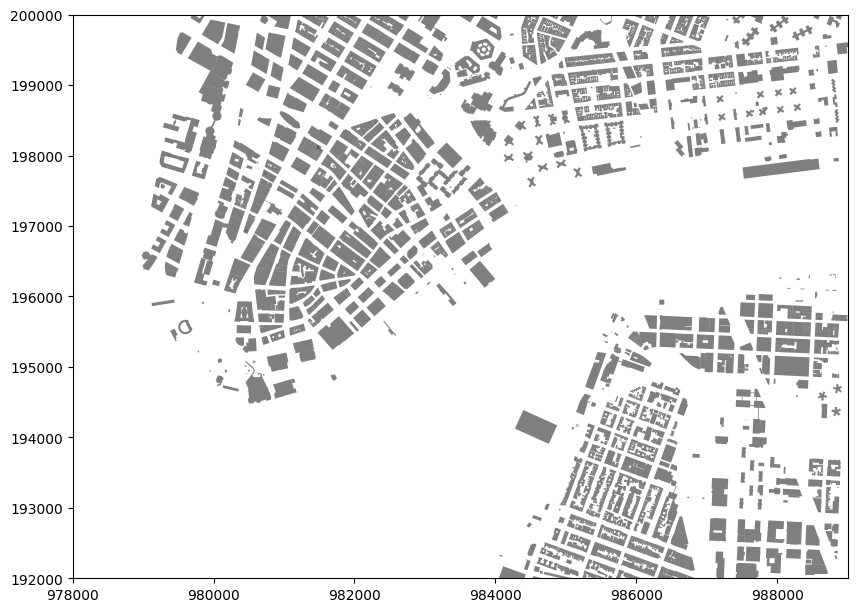

In [23]:
ax = buildings_gdf.plot(
    facecolor='black',
    alpha=0.5,
    figsize=(10, 10),
)
ax.set_xlim([978_000, 989_000])
ax.set_ylim([192_000, 200_000])

In [24]:
# Load the tax lots dataset from the Shapefile
tax_lots_gdf = gpd.read_file(
    Path(DATA_DIRECTORY) / 'nyc_mappluto_24v3_1_unclipped_shp',
    bbox=bbox_gdf,
    use_arrow=True
).to_crs(2263)

(192000.0, 200000.0)

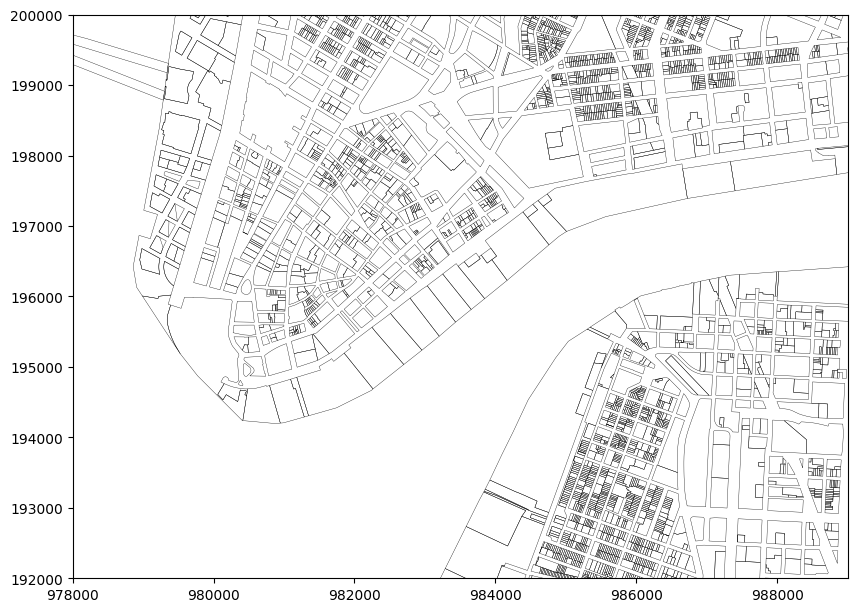

In [25]:
ax = tax_lots_gdf.plot(facecolor='none', lw=0.25, figsize=(10, 10))
ax.set_xlim([978_000, 989_000])
ax.set_ylim([192_000, 200_000])

In [26]:
# Convert the index column for the tax lots to a string
tax_lots_gdf['BBL'] = tax_lots_gdf['BBL'].astype(int).astype(str)

In [27]:
# Join the datat based on the borough, block, lot (BBL) identifier
joined_gdf = buildings_gdf.set_index('base_bbl').join(tax_lots_gdf.set_index('BBL'), rsuffix='_lots')

<Axes: >

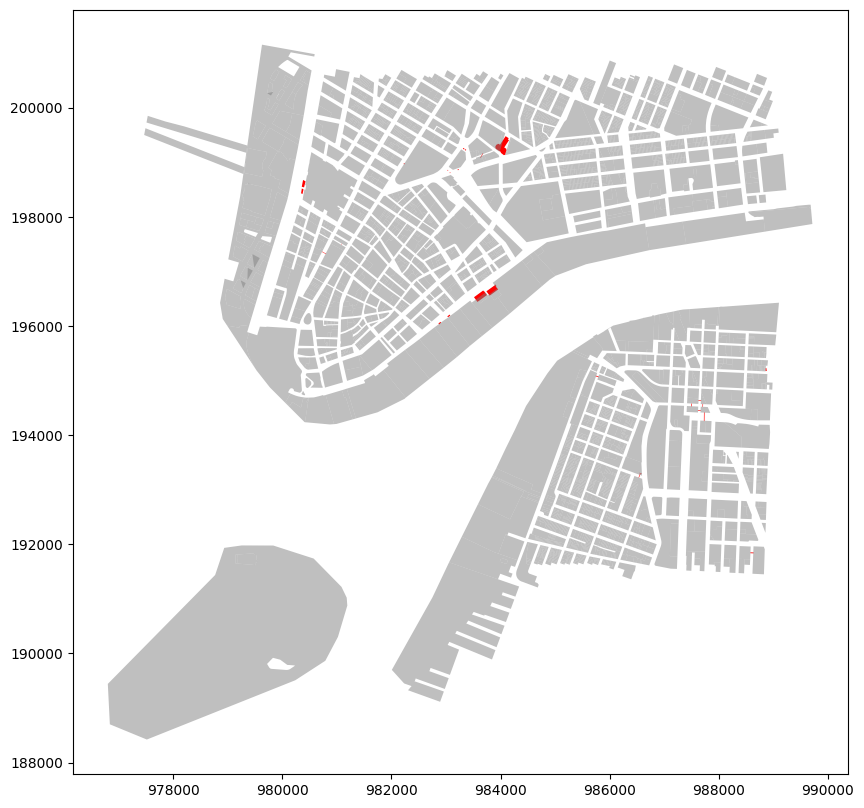

In [29]:
# For the spatial join, we need to use points to avoid duplicate intersections
# Create a copy of the buildings dataset
buildings_points_gdf = buildings_gdf.copy()
# Copy the original geometry to a new column just in case
buildings_points_gdf['footprint_geometry'] = buildings_points_gdf['geometry']
# Use the centroid of the floorplate to set up teh spatial join
buildings_points_gdf['geometry'] = buildings_points_gdf['geometry'].centroid

# Make the spatial join
sjoined_gdf = buildings_points_gdf.sjoin(tax_lots_gdf, predicate='intersects', how='left')

# Put the geometry back
sjoined_gdf['geometry'] = sjoined_gdf['footprint_geometry']

# Show which geometry was not joined
ax = sjoined_gdf[sjoined_gdf['index_right'].isna()].plot(facecolor='red', figsize=(10, 10))
tax_lots_gdf.plot(ax=ax, facecolor='grey', alpha=0.5, lw=0.25)

(192000.0, 200000.0)

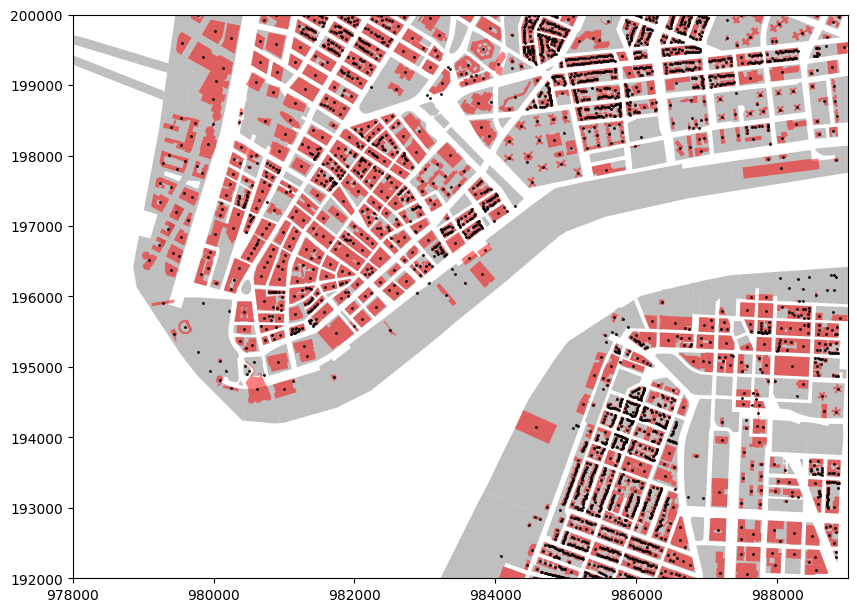

In [31]:
# Plot the centroid vs. the original data
ax = tax_lots_gdf.plot(facecolor='grey', alpha=0.5, figsize=(10, 10))
buildings_gdf.plot(ax=ax, facecolor='red', alpha=0.5, lw=0.25)
buildings_points_gdf.plot(ax=ax, color='black', markersize=1)
ax.set_xlim([978_000, 989_000])
ax.set_ylim([192_000, 200_000])

# Column Operations and Apply Functions

<Axes: >

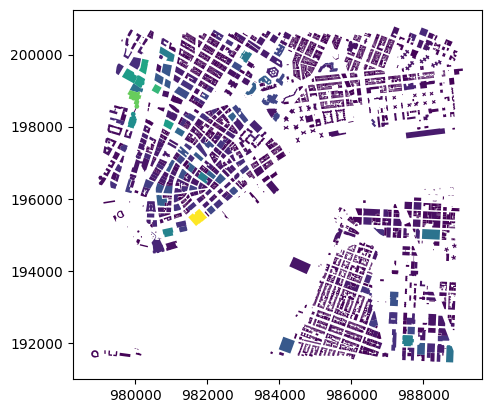

In [32]:
# Create a new column
buildings_gdf['gross_floor_area'] = buildings_gdf.to_crs(2263).geometry.area * buildings_gdf['heightroof'] / 10
buildings_gdf.plot(column='gross_floor_area')

<Axes: >

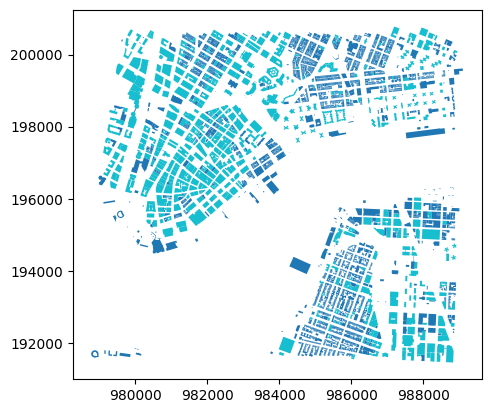

In [33]:
# Create a new column using apply()
buildings_gdf['taller_than_100'] = buildings_gdf.apply(lambda r: r['heightroof'] > 100, axis=1)
buildings_gdf.plot(column='taller_than_100')

# Writing to Rhino

In [35]:
# Install the Python module for working with Rhino files
# See more: https://mcneel.github.io/rhino3dm/python/api/index.html
!pip install rhino3dm --quiet

In [36]:
# Import the module now that you have it
import rhino3dm

In [40]:
# Creates a new file
new_3dm = rhino3dm.File3dm()
new_3dm.Settings.ModelUnitSystem = rhino3dm.UnitSystem.Feet

In [41]:
# Be sure to run this just once — otherwise you will add the layers multiple times
# Let's set a "constant" variable for red
RED_RGBA = (255, 0, 0, 255)
BLUE_RGBA = (0, 0, 255, 255)

# Add the layer with a name and color
new_3dm.Layers.AddLayer("Buildings", RED_RGBA)
new_3dm.Layers.AddLayer("Tax Lots", BLUE_RGBA)

1

In [42]:
# Let's define geometry attributes that we can re-use
bldg_attributes = rhino3dm.ObjectAttributes()
bldg_attributes.LayerIndex = 0

tax_lot_attributes = rhino3dm.ObjectAttributes()
tax_lot_attributes.LayerIndex = 1

In [43]:
# You can see which layers exist
for l in new_3dm.Layers:
    print(l.FullPath)

Buildings
Tax Lots


In [45]:
# Add the buildings
bldg_guids = []
for i, bldg in buildings_gdf.iterrows():
    polyline_pts = []
    for pt in bldg.geometry.exterior.coords:
        polyline_pts.append(rhino3dm.Point3d(pt[0], pt[1], 0))

    polyline = rhino3dm.Polyline(polyline_pts).ToPolylineCurve()
    guid = new_3dm.Objects.Add(polyline, bldg_attributes)
    bldg_guids.append(guid)

In [44]:
# Add the tax lots
tax_lot_guids = []
for i, tax_lot in tax_lots_gdf.iterrows():
    polyline_pts = []

    if tax_lot.geometry.geom_type == 'MultiPolygon':
        for pt in tax_lot.geometry.geoms[0].exterior.coords:
            polyline_pts.append(rhino3dm.Point3d(pt[0], pt[1], 0))

    else:
        for pt in tax_lot.geometry.exterior.coords:
            polyline_pts.append(rhino3dm.Point3d(pt[0], pt[1], 0))

    polyline = rhino3dm.Polyline(polyline_pts).ToPolylineCurve()
    guid = new_3dm.Objects.Add(polyline, tax_lot_attributes)
    tax_lot_guids.append(guid)

In [46]:
# Save the file
# The second argument is the version number
new_3dm.Write('example_rhino_file.3dm', 7)

True

# Loading in Grasshopper with a CSV and GUIDs

In [47]:
# We can use Pandas to make a CSV (no geometry needed)
import pandas as pd

In [55]:
# Create basic dataframe
bldg_data_for_rhino_df = pd.DataFrame({
    'guid': bldg_guids
})
# Join on the original index
bldg_data_for_rhino_df = bldg_data_for_rhino_df.join(joined_gdf.reset_index())

In [60]:
# Load this into Rhino to match the GUIDs
# We'll use the semicolon as the separator, as the data itself has commas
# We will also use index=False to avoid adding the extra index column
bldg_data_for_rhino_df.to_csv('bldg_data_for_rhino.csv', sep=';', index=False)